# BOW and TFIDF

```yaml
course:   DS 5001 
module:   05 5 Lab
topic:    BOW and TFIDF
author:   R.C. Alvarado
date:     13 February 2024
```

# Set Up

## Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly_express as px

In [2]:
sns.set()

## Config

Change this to match the location of your data files.

In [3]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home'] 
output_dir = config['DEFAULT']['output_dir']
data_prefix = 'austen-melville'

In [4]:
OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']
bags = dict(
    SENTS = OHCO[:4],
    PARAS = OHCO[:3],
    CHAPS = OHCO[:2],
    BOOKS = OHCO[:1]
)

In [5]:
bag = 'CHAPS'
# bag = 'BOOKS'

# Prepare the data

## Import tables

In [6]:
LIB = pd.read_csv(f"{output_dir}/{data_prefix}-LIB.csv").set_index('book_id')
TOKEN = pd.read_csv(f'{output_dir}/{data_prefix}-CORPUS.csv').set_index(OHCO).dropna()
VOCAB = pd.read_csv(f'{output_dir}/{data_prefix}-VOCAB_RANKED.csv').set_index('term_str').dropna()
# POS_GROUP = pd.read_csv(f'{output_dir}/{data_prefix}-POS_GROUP.csv').set_index('pos_group')

In [7]:
TOKEN.reset_index().book_id.value_counts().sort_index()

book_id
105       83613
121       77586
141      160366
158      160884
161      119858
946       23115
1212      33241
1342     122089
1900     108015
2701     215461
4045     102347
8118     119230
10712    143251
13720     96874
13721    102078
15422     65510
15859     75232
21816     95169
34970    155024
Name: count, dtype: int64

# Create BOW from TOKEN

We can create a BOW with a **split-apply-combine** pattern that counts instances of words for each bag.

We group by `bag + ['term_str']`.


In [8]:
BOW = TOKEN.groupby(bags[bag]+['term_str']).term_str.count().to_frame('n') 

In [9]:
BOW.head()

n
book_id chap_id term_str   
105     1       1         2
                15        1
                16        1
                1760      1
                1784      1

# Document-Term Count Matrix

We create a document-term count matrix simply bu **unstacking** the BOW, which converts it from a narrow to a wide representation. 

Note, these operations are slower than using `groupby()`.

In [10]:
DTCM = BOW.n.unstack(fill_value=0)

In [11]:
DTCM.head(10)

term_str         0  1  10  100  1000  10000  10000000  10440  10800  10th  \
book_id chap_id                                                             
105     1        0  2   0    0     0      0         0      0      0     0   
        2        0  0   0    0     0      0         0      0      0     0   
        3        0  0   0    0     0      0         0      0      0     0   
        4        0  0   0    0     0      0         0      0      0     0   
        5        0  0   0    0     0      0         0      0      0     0   
        6        0  0   0    0     0      0         0      0      0     0   
        7        0  0   0    0     0      0         0      0      0     0   
        8        0  0   0    0     0      0         0      0      0     0   
        9        0  0   0    0     0      0         0      0      0     0   
        10       0  0   0    0     0      0         0      0      0     0   

term_str         ...  zoroaster  zozo  zuma  zur  à  æneas  æniad  æson  \
book_id chap_id  ...                                                      
105     1        ...          0     0     0    0  0      0      0     0   
        2        ...          0     0     0    0  0      0      0     0   
        3        ...          0     0     0    0  0      0      0     0   
        4        ...          0     0     0    0  0      0      0     0   
        5        ...          0     0     0    0  0      0      0     0   
        6        ...          0     0     0    0  0      0      0     0   
        7        ...          0     0     0    0  0      0      0     0   
        8        ...          0     0     0    0  0      0      0     0   
        9        ...          0     0     0    0  0      0      0     0   
        10       ...          0     0     0    0  0      0      0     0   

term_str         æsops  ł20000  
book_id chap_id                 
105     1            0       0  
        2            0       0  
        3            0       0  
        4            0       0  
        5            0       0  
        6            0       0  
        7            0       0  
        8            0       0  
        9            0       0  
        10           0       0  

[10 rows x 40281 columns]

In [12]:
DTCM.sum()

term_str
0          2
1         23
10         6
100        2
1000       2
          ..
æneas      1
æniad      1
æson       2
æsops      1
ł20000     1
Length: 40281, dtype: int64

## Interlude: Types and Tokens by DOC

DOC is a table of bags.

We call TYPE/TOKEN ratio PKR.

PKR varies by bag.

In [13]:
DOC = DTCM.sum(1).to_frame('n_tokens')
DOC['n_types'] = DTCM.astype('bool').sum(1)
DOC['pkr'] = DOC.n_types / DOC.n_tokens
DOC = DOC.join(LIB[['author','title']])

In [14]:
DOC.sort_values('pkr').head(20).style.background_gradient(cmap='YlGnBu')

CHAPS


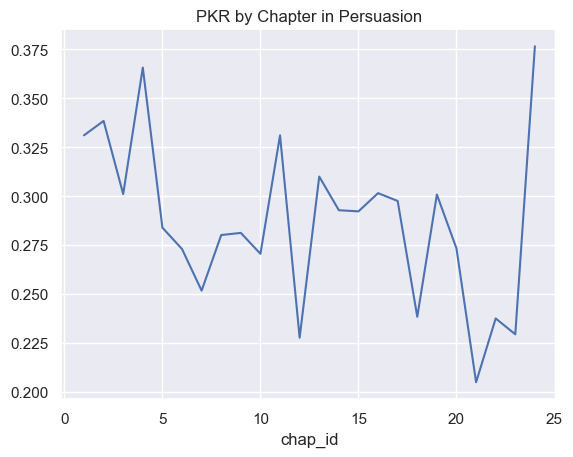

In [15]:
print(bag)
if bag == 'CHAPS':
    DOC.loc[105, 'pkr'].plot(title="PKR by Chapter in Persuasion", label='title');

# Compute TFIDF

In [16]:
tf_method = 'sum'         # sum, max, log, double_norm, raw, binary
tf_norm_k = .5            # only used for double_norm
idf_method = 'standard'   # standard, max, smooth
gradient_cmap = 'YlGnBu'  # YlGn, GnBu, YlGnBu; For tables; see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html 

## Compute TF

In [17]:
# We could do all this directly in the BOW table
# BOW.groupby(['book_id','chap_num']).apply(lambda x: x.n / x.n.sum())

In [18]:
print('TF method:', tf_method)

if tf_method == 'sum':
    TF = DTCM.T / DTCM.T.sum()

elif tf_method == 'max':
    TF = DTCM.T / DTCM.T.max()
    
elif tf_method == 'log':
    TF = np.log2(1 + DTCM.T)
    
elif tf_method == 'raw':
    TF = DTCM.T
    
elif tf_method == 'double_norm':
    TF = DTCM.T / DTCM.T.max()
    
elif tf_method == 'binary':
    TF = DTCM.T.astype('bool').astype('int')
    
TF = TF.T

TF method: sum


In [19]:
TF.head()

term_str           0         1   10  100  1000  10000  10000000  10440  10800  \
book_id chap_id                                                                 
105     1        0.0  0.000762  0.0  0.0   0.0    0.0       0.0    0.0    0.0   
        2        0.0  0.000000  0.0  0.0   0.0    0.0       0.0    0.0    0.0   
        3        0.0  0.000000  0.0  0.0   0.0    0.0       0.0    0.0    0.0   
        4        0.0  0.000000  0.0  0.0   0.0    0.0       0.0    0.0    0.0   
        5        0.0  0.000000  0.0  0.0   0.0    0.0       0.0    0.0    0.0   

term_str         10th  ...  zoroaster  zozo  zuma  zur    à  æneas  æniad  \
book_id chap_id        ...                                                  
105     1         0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0    0.0   
        2         0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0    0.0   
        3         0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0    0.0   
        4         0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0    0.0   
        5         0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0    0.0   

term_str         æson  æsops  ł20000  
book_id chap_id                       
105     1         0.0    0.0     0.0  
        2         0.0    0.0     0.0  
        3         0.0    0.0     0.0  
        4         0.0    0.0     0.0  
        5         0.0    0.0     0.0  

[5 rows x 40281 columns]

## Compute DF

In [20]:
DF = DTCM.astype('bool').sum() 

In [21]:
DF

term_str
0          1
1         12
10         5
100        2
1000       2
          ..
æneas      1
æniad      1
æson       1
æsops      1
ł20000     1
Length: 40281, dtype: int64

## Compute IDF

In [22]:
N = DTCM.shape[0]

In [23]:
print('IDF method:', idf_method)

if idf_method == 'standard':
    IDF = np.log2(N / DF)

elif idf_method == 'max':
    IDF = np.log2(DF.max() / DF) 

elif idf_method == 'smooth':
    IDF = np.log2((1 + N) / (1 + DF)) + 1

IDF method: standard


In [24]:
IDF

term_str
0         10.210671
1          6.625709
10         7.888743
100        9.210671
1000       9.210671
            ...    
æneas     10.210671
æniad     10.210671
æson      10.210671
æsops     10.210671
ł20000    10.210671
Length: 40281, dtype: float64

## Compute TFIDF

In [25]:
TFIDF = TF * IDF

In [26]:
TFIDF.head()

term_str           0         1   10  100  1000  10000  10000000  10440  10800  \
book_id chap_id                                                                 
105     1        0.0  0.005048  0.0  0.0   0.0    0.0       0.0    0.0    0.0   
        2        0.0  0.000000  0.0  0.0   0.0    0.0       0.0    0.0    0.0   
        3        0.0  0.000000  0.0  0.0   0.0    0.0       0.0    0.0    0.0   
        4        0.0  0.000000  0.0  0.0   0.0    0.0       0.0    0.0    0.0   
        5        0.0  0.000000  0.0  0.0   0.0    0.0       0.0    0.0    0.0   

term_str         10th  ...  zoroaster  zozo  zuma  zur    à  æneas  æniad  \
book_id chap_id        ...                                                  
105     1         0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0    0.0   
        2         0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0    0.0   
        3         0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0    0.0   
        4         0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0    0.0   
        5         0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0    0.0   

term_str         æson  æsops  ł20000  
book_id chap_id                       
105     1         0.0    0.0     0.0  
        2         0.0    0.0     0.0  
        3         0.0    0.0     0.0  
        4         0.0    0.0     0.0  
        5         0.0    0.0     0.0  

[5 rows x 40281 columns]

## Move things to their places

In [27]:
VOCAB['df'] = DF
VOCAB['idf'] = IDF

In [28]:
BOW['tf'] = TF.stack()
BOW['tfidf'] = TFIDF.stack()

# Apply

In [29]:
def top_books_for_term(term_str):
    X = BOW.join(LIB).query(f"term_str == '{term_str}'").groupby(['author','title'])\
        .agg({'tfidf':'mean', 'n':'sum', 'tf':'sum'})
    return px.scatter(X.reset_index(), 'n','tfidf', color='author', size='tf',
                      hover_name='title', 
                      height=500, width=600, title=f"{term_str}")

In [30]:
top_books_for_term('ship')

In [31]:
top_books_for_term('joy')

In [32]:
top_books_for_term('england')

In [33]:
top_books_for_term('america')

In [34]:
top_books_for_term('anne')

In [35]:
top_books_for_term('whale')

# Save

In [36]:
save_path = f"{output_dir}/{data_prefix}"
LIB.to_csv(f'{save_path}-LIB.csv')
VOCAB.to_csv(f'{save_path}-VOCAB-{bag}.csv')
BOW.to_csv(f'{save_path}-BOW-{bag}.csv')
DTCM.to_csv(f'{save_path}-DTCM-{bag}.csv')
DOC.to_csv(f'{save_path}-DOC-{bag}.csv')
TFIDF.to_csv(f"{save_path}-TFIDF-{bag}.csv")